In [211]:
import numpy as np
import dill
import importlib
import os
import matplotlib.pyplot as plt
import data_visualization as dv
import copy
import numba as nb
import time
'''
v4 Uses the object imported from the py file class which is very similar to the Optimal_Stopping_Function_v3

As of 1/13/23, the only change is the addition of the decision to action delay
'''

'\nv4 Uses the object imported from the py file class which is very similar to the Optimal_Stopping_Function_v3\n\nAs of 1/13/23, the only change is the addition of the decision to action delay\n'

# Select Exp1 or Exp2


In [188]:
experiment = "Exp1"

In [189]:
import read_data_functions as rdf
import plot_functions as pf
import Optimal_Stopping_Object
importlib.reload(Optimal_Stopping_Object)
import Optimal_Stopping_Object as oso
import Subject_Object_v2

# Initial Thangs


In [190]:
plt.style.use("cashaback_dark")
wheel = dv.ColorWheel()

# Initial thangs
os.chdir(f"D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}")
PATH = os.getcwd()
SAVE_PATH = f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH + "\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH + "\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
num_subjects = len(figures_pull_list)
if experiment == "Exp2":
    tp3_title = "Win = 1\nIncorrect = 0\nIndecision = 0"
    tp4_title = "Win = 1\nIncorrect = -1\nIndecision = 0"
    tp5_title = "Win = 1\nIncorrect = 0\nIndecision = -1"
    tp6_title = "Win = 1\nIncorrect = -1\nIndecision = -1"
    trial_block_titles = [tp3_title, tp4_title, tp5_title, tp6_title]
    num_blocks = len(trial_block_titles)
    xlabel = "Payoff Condition"
if experiment == "Exp1":
    tp3_title = "1000 (50)"
    tp4_title = "1000 (150)"
    tp5_title = "1100 (50)"
    tp6_title = "1100 (150)"
    tp7_title = "1200 (50)"
    tp8_title = "1200 (150)"
    trial_block_titles = [tp3_title, tp4_title, tp5_title, tp6_title, tp7_title, tp8_title]
    num_blocks = len(trial_block_titles)
    xlabel = "Mean [SD] Agent Decision Time (ms)"
num_subjects

20

# Pickle Data


In [191]:
if "subject_objects" not in locals():
    subject_objects = rdf.generate_subject_objects(experiment)
    subject_objects2 = copy.deepcopy(subject_objects)
    # group = Subject_Object_v2.Group(subject_objects, select_trials = 'All Trials', num_stds_for_reaction_time = 2,
    #                                     task_leave_time_metric_name = 'player_pos_task_leave_time', task_movement_time_metric_name = 'player_pos_task_movement_time',
    #                                     reaction_time_metric_name = 'player_pos_reaction_time', reaction_movement_time_metric_name = 'player_pos_reaction_movement_time')
    # group.analyze_data()
    group = Subject_Object_v2.Group(
        subject_objects2,
        select_trials="All Trials",
        num_stds_for_reaction_time=2,
        task_leave_time_metric_name="player_velocity_task_leave_time_thresh",
        task_movement_time_metric_name="player_velocity_task_movement_time_thresh",
        reaction_time_metric_name="player_velocity_reaction_time_thresh",
        reaction_movement_time_metric_name="player_velocity_reaction_movement_time_thresh",
    )
    group.analyze_data()

In [192]:
# from pyheat import PyHeat
# # os.chdir(os.getcwd())
# ph = PyHeat('D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\src\Optimal_Stopping_Object.py')
# ph.create_heatmap()

# Generate Models

In [193]:
if experiment == "Exp1":
    rt = np.nanmedian(group.reaction_time, axis=1) - 15
    rt_sd = np.nanstd(group.reaction_time, axis=1)
elif experiment == "Exp2":
    rt = np.nanmedian(group.react_reaction_time_only_react, axis=1) - 30
    rt_sd = np.nanmedian(np.nanstd(group.reaction_time, axis=2))

mt = np.min(np.nanmedian(group.player_task_movement_time, axis=2), axis=1)  # Get movement time for the condition where they tried the hardest
mt_sd = np.median(np.nanstd(group.player_task_movement_time, axis=2), axis=1)
time_sd = np.array([(np.nanstd(group.coincidence_reach_time, axis=1))] * num_blocks).T
perc_wins_both_reach = group.perc_gamble_wins_when_both_decide
gamble_sd = np.nanstd(group.player_gamble_task_leave_time, axis=2)
agent_sds = np.nanstd(group.agent_task_leave_time, axis=2)
agent_means = np.nanmean(group.agent_task_leave_time, axis=2)

model_expected_list = {}
model_true_list = {}
for i in range(num_subjects):
    subname = figures_pull_list[i]
    model_expected = oso.ModelConstructor(
        experiment=experiment,
        num_blocks=num_blocks,
        num_timesteps=1800,
        BETA_ON=False,
        agent_means=agent_means[i, :],
        agent_sds=agent_sds[i, :],
        reaction_time={"true": rt[i], "exp": rt[i]},
        movement_time={"true": mt[i], "exp": mt[i]},
        reaction_sd={"true": rt_sd[i], "exp": rt_sd[i]},
        movement_sd={"true": mt_sd[i], "exp": mt_sd[i]},
        timing_sd={"true": time_sd[i], "exp": time_sd[i]},
        perc_wins_when_both_reach=perc_wins_both_reach[i],
        gamble_delay_known=True,
        gamble_sd_known=True,
        gamble_decision_sd={"true": gamble_sd[i], "exp": 10},
        gamble_delay={"true": 125, "exp": 50},
        expected=True,
    )

    model_true = oso.ModelConstructor(
        experiment=experiment,
        num_blocks=num_blocks,
        num_timesteps=1800,
        BETA_ON=False,
        agent_means=agent_means[i, :],
        agent_sds=agent_sds[i, :],
        reaction_time={"true": rt[i], "exp": rt[i]},
        movement_time={"true": mt[i], "exp": mt[i]},
        reaction_sd={"true": rt_sd[i], "exp": rt_sd[i]},
        movement_sd={"true": mt_sd[i], "exp": mt_sd[i]},
        timing_sd={"true": time_sd[i], "exp": time_sd[i]},
        perc_wins_when_both_reach=perc_wins_both_reach[i],
        gamble_delay_known=True,
        gamble_sd_known=True,
        gamble_decision_sd={"true": gamble_sd[i], "exp": 10},
        gamble_delay={"true": 125, "exp": 50},
        expected=False,
    )
    # Fit true model
    model_true.fit_model(
        model_true.player_behavior.wtd_leave_target_time,
        np.nanmedian(group.player_task_leave_time, axis=2)[i],
    )
    # Fit expected model
    model_expected.fit_model(
        model_expected.player_behavior.wtd_leave_target_time,
        np.nanmedian(group.player_task_leave_time, axis=2)[i],
    )
    # Update dicts
    model_true_list.update({subname: model_true})
    model_expected_list.update({subname: model_expected})

Put Individual Models into One Object for easy plotting

In [194]:
models_true = oso.Group_Models(model_true_list,num_blocks,model_true.inputs.num_timesteps,)
models_expected = oso.Group_Models(model_expected_list,num_blocks,model_true.inputs.num_timesteps,)

# Plots

In [195]:
save = False

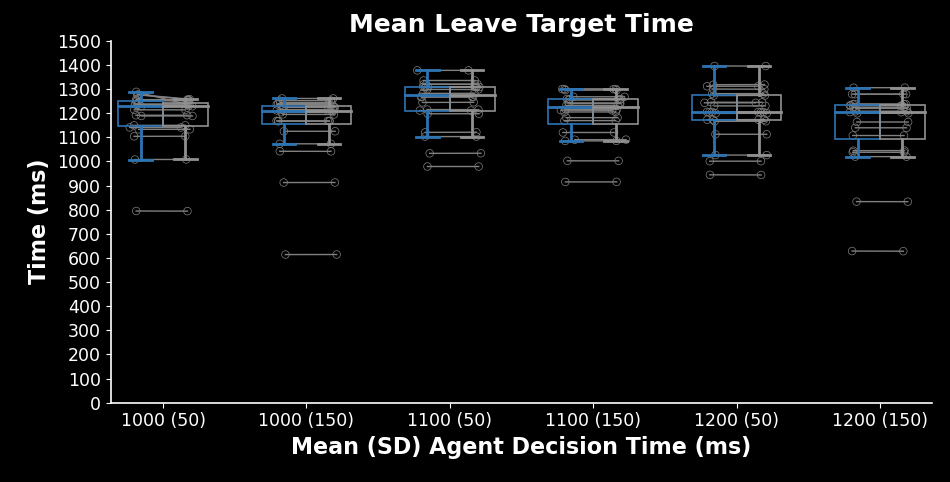

In [196]:
metric = np.nanmedian(group.combine_all_subjects('player_task_leave_time'),axis=2) 
true_player_metric = models_true.get_metric('player_behavior','wtd_leave_target_time',metric_type='fit')
w,h = 12,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,1600,100)
bw = 0.75
pf.multi_boxplot(ax,metric,xlocs=xlocs-bw/2,box_width = bw,colors = wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/2,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

pf.multi_boxplot(ax,true_player_metric,xlocs=xlocs+bw/2,box_width = bw,colors = wheel.grey)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/2,data_list=optimal_metric.T, noise_scale=0.01, include_mean = False, circle_size=30)
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-bw/1.75,bw/1.75])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],true_player_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
# ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw)
# ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Mean Leave Target Time')
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Wins

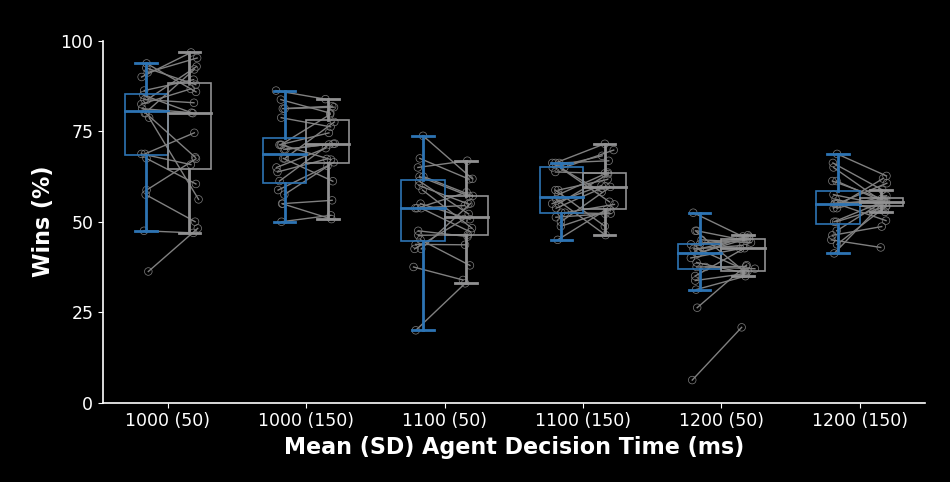

In [197]:
metric = group.combine_all_subjects('player_perc_wins') 
true_player_metric = models_true.get_metric('score_metrics','prob_win',metric_type='fit')*100

w,h = 12,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
pf.multi_boxplot(ax,metric,xlocs=xlocs-bw/2,box_width = bw,colors = wheel.seth_blue)
pf.multi_boxplot(ax,true_player_metric,xlocs=xlocs+bw/2,box_width = bw,colors = wheel.grey)
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-bw/1.75,bw/1.75])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],true_player_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Wins (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'wins_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Indecisions

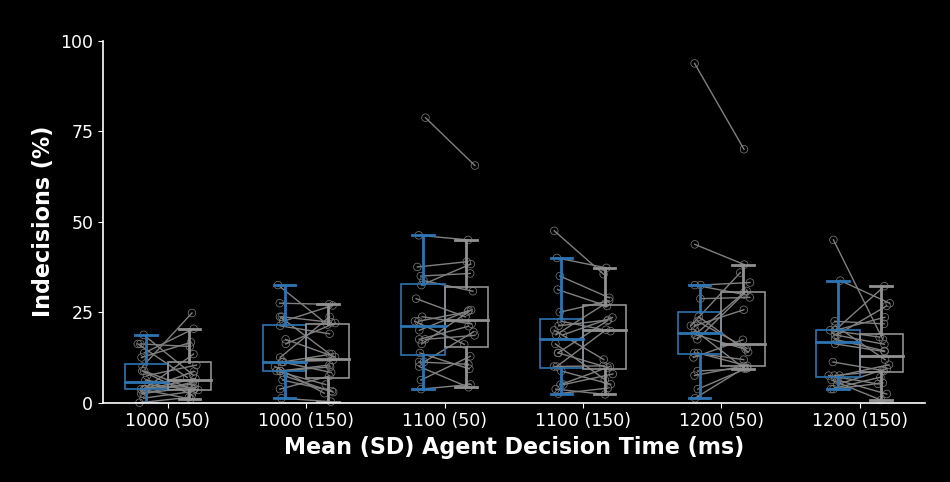

In [198]:
metric = group.combine_all_subjects('player_perc_indecisions') 
true_player_metric = models_true.get_metric('score_metrics','prob_indecision',metric_type='fit')*100

w,h = 12,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
pf.multi_boxplot(ax,metric,xlocs=xlocs-bw/2,box_width = bw,colors = wheel.seth_blue)
pf.multi_boxplot(ax,true_player_metric,xlocs=xlocs+bw/2,box_width = bw,colors = wheel.grey)
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-bw/1.75,bw/1.75])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],true_player_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Indecisions (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'indecisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Incorrects

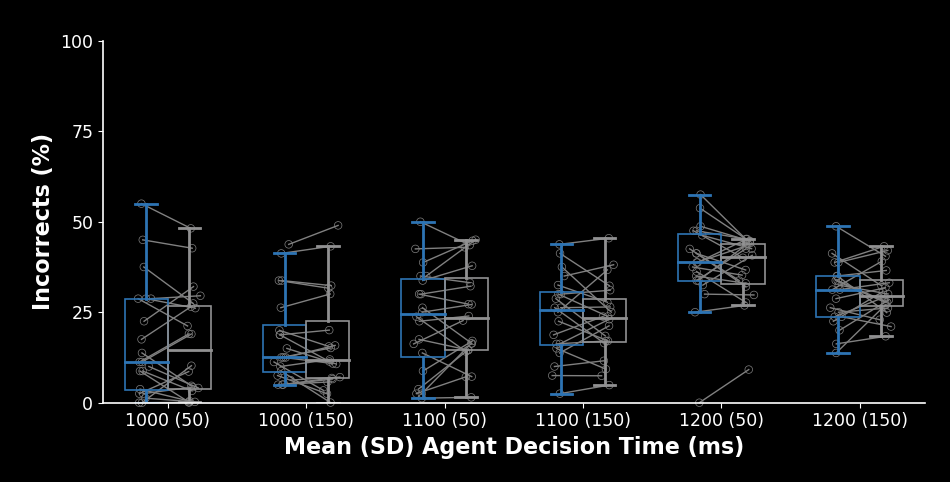

In [199]:
metric = group.combine_all_subjects('player_perc_incorrects') 
true_player_metric = models_true.get_metric('score_metrics','prob_incorrect',metric_type='fit')*100

w,h = 12,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
pf.multi_boxplot(ax,metric,xlocs=xlocs-bw/2,box_width = bw,colors = wheel.seth_blue)
pf.multi_boxplot(ax,true_player_metric,xlocs=xlocs+bw/2,box_width = bw,colors = wheel.grey)
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-bw/1.75,bw/1.75])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],true_player_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Incorrects (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'incorrects_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Reaction/Gamble Decisions

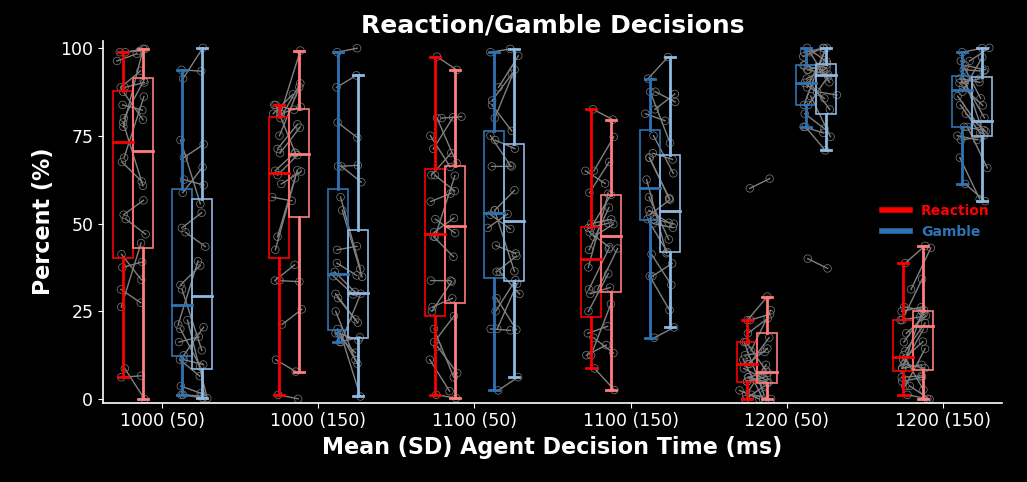

In [200]:

data_metric1 = group.combine_all_subjects('perc_reaction_decisions')
data_metric2 = group.combine_all_subjects('perc_gamble_decisions')
true_player_metric1 = models_true.get_metric('player_behavior','prob_selecting_reaction',metric_type='fit')*100
true_player_metric2 = models_true.get_metric('player_behavior','prob_selecting_gamble',metric_type='fit')*100
# Out of x number of Reaction/Gamble decisions, how many of them were indecisions
w,h = 13,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.33
pf.multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
pf.multi_boxplot(ax,true_player_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],true_player_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
pf.multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
pf.multi_boxplot(ax,true_player_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],true_player_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Reaction/Gamble Decisions')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

Reaction/Gamble Leave Times

c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


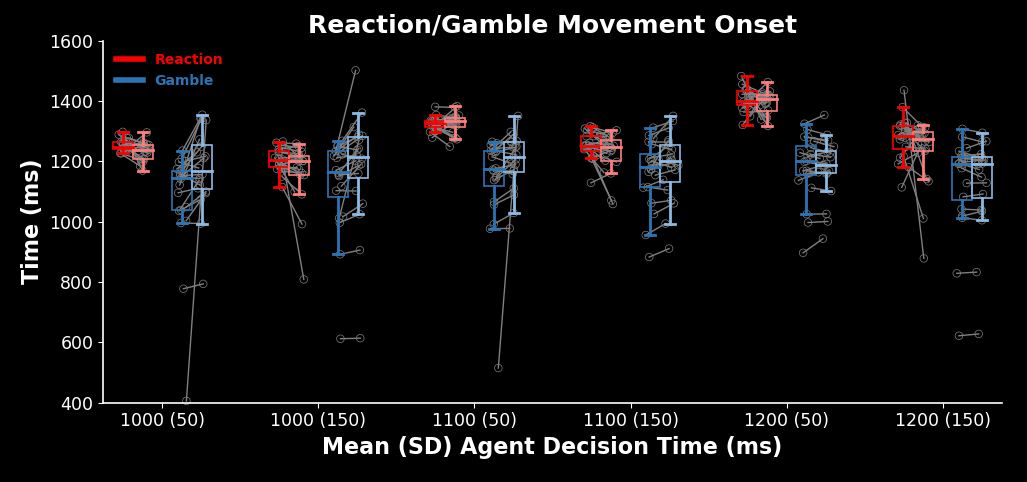

In [201]:
data_metric1 = np.nanmedian(group.player_reaction_task_leave_time,axis=2)
data_metric2 = np.nanmedian(group.player_gamble_task_leave_time,axis=2)
true_player_metric1 = models_true.get_metric('player_behavior','reaction_leave_time',metric_type='fit')
true_player_metric2 = models_true.get_metric('player_behavior','gamble_leave_time',metric_type='fit')
# Out of x number of Reaction/Gamble decisions, how many of them were indecisions
w,h = 13,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(400,1700,200)


bw = 0.33
pf.multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
pf.multi_boxplot(ax,true_player_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],true_player_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
pf.multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
pf.multi_boxplot(ax,true_player_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],true_player_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw)
ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs)
ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Reaction/Gamble Movement Onset')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

Wins That Were Gambles

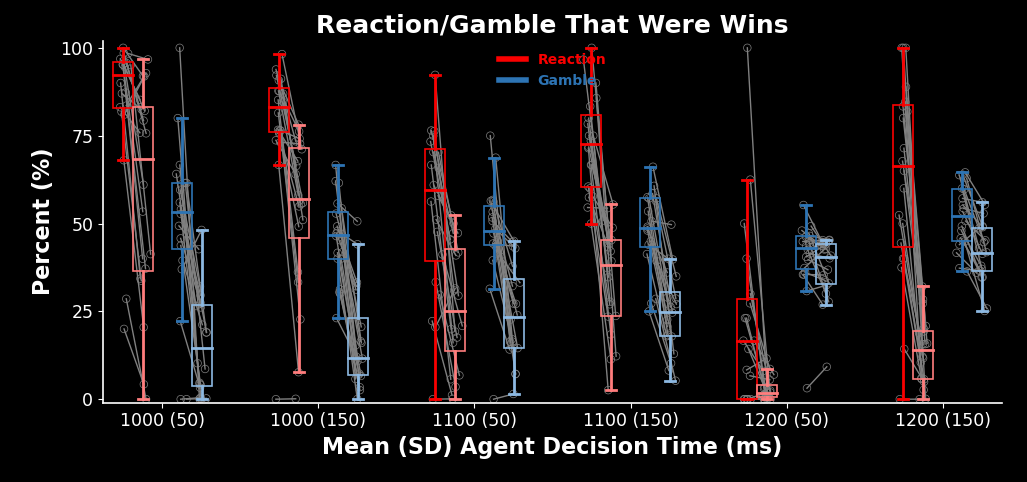

In [202]:
# Out of x number of Reaction/Gamble decisions, how many of them were wins
data_metric1 = group.perc_reactions_that_were_wins
data_metric2 = group.perc_gambles_that_were_wins
true_player_metric1 = models_true.get_metric('score_metrics','prob_win_reaction','prob_win',metric_type='fit')*100
true_player_metric2 = models_true.get_metric('score_metrics','prob_win_gamble','prob_win',metric_type='fit')*100
# Out of x number of Reaction/Gamble decisions, how many of them were wins
w,h = 13,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.33
pf.multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
pf.multi_boxplot(ax,true_player_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],true_player_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
pf.multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
pf.multi_boxplot(ax,true_player_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],true_player_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Reaction/Gamble That Were Wins')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

Incorrects That were Reaction/Gamble

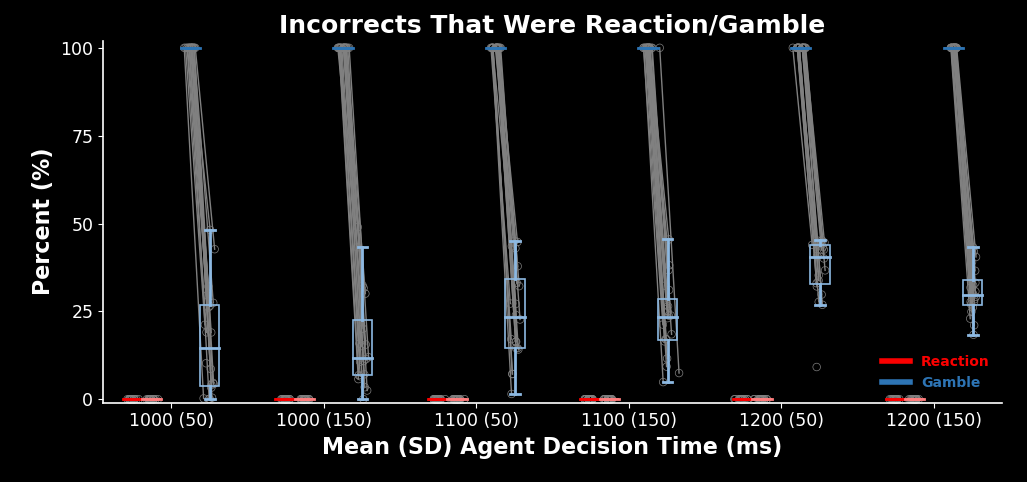

In [203]:
# Out of x number of Reaction/Gamble decisions, how many of them were incorrects
data_metric1 = group.combine_all_subjects('perc_incorrects_that_were_reactions') 
data_metric2 = group.combine_all_subjects('perc_incorrects_that_were_gambles') 
true_player_metric1 = models_true.get_metric('score_metrics','prob_incorrect_reaction','prob_incorrect',metric_type='fit')*100
true_player_metric2 = models_true.get_metric('score_metrics','prob_incorrect_gamble','prob_incorrect',metric_type='fit')*100
# Out of x number of Reaction/Gamble decisions, how many of them were incorrects
w,h = 13,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.33
pf.multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
pf.multi_boxplot(ax,true_player_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],true_player_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
pf.multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
pf.multi_boxplot(ax,true_player_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],true_player_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Incorrects That Were Reaction/Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

Indecisions that were Reaction/Gamble

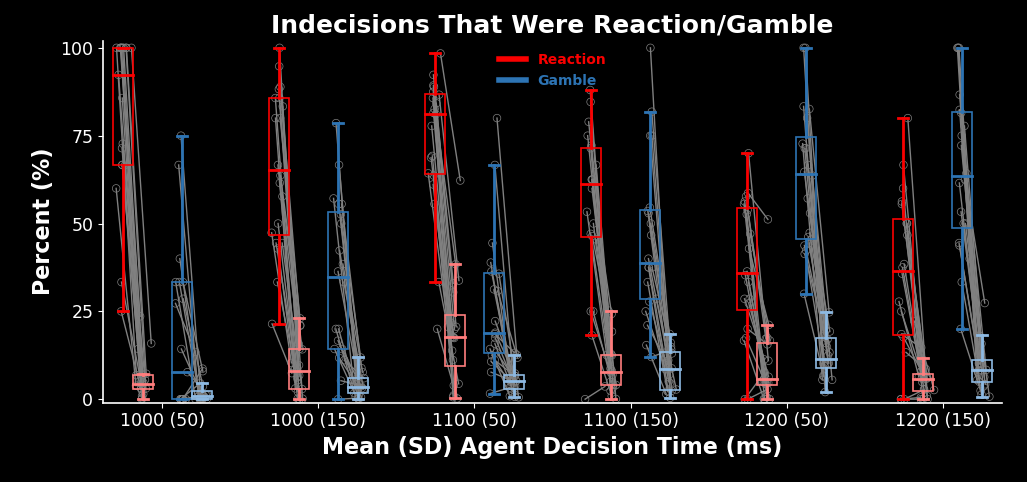

In [204]:
# Out of x number of Reaction/Gamble decisions, how many of them were indecisions
data_metric1 = group.combine_all_subjects('perc_indecisions_that_were_reactions') 
data_metric2 = group.combine_all_subjects('perc_indecisions_that_were_gambles') 
true_player_metric1 = models_true.get_metric('score_metrics','prob_indecision_reaction','prob_indecision',metric_type='fit')*100
true_player_metric2 = models_true.get_metric('score_metrics','prob_indecision_gamble','prob_indecision',metric_type='fit')*100
# Out of x number of Reaction/Gamble decisions, how many of them were indecisions
w,h = 13,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.33
pf.multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
pf.multi_boxplot(ax,true_player_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],true_player_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
pf.multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
pf.multi_boxplot(ax,true_player_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],true_player_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Indecisions That Were Reaction/Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

Reaction/Gamble That Were Wins

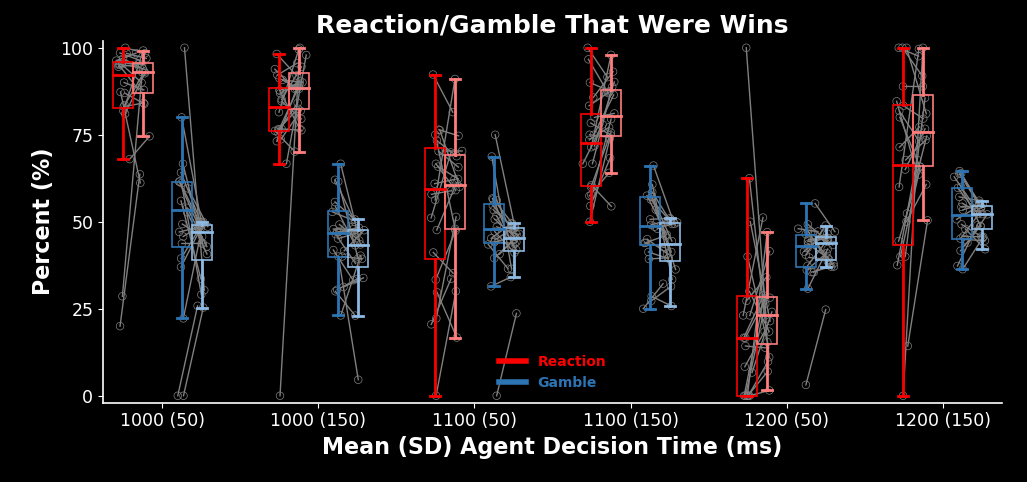

In [207]:
# Out of x number of Reaction/Gamble decisions, how many of them were winss
data_metric1 = group.combine_all_subjects('perc_reactions_that_were_wins') 
data_metric2 = group.combine_all_subjects('perc_gambles_that_were_wins') 
true_player_metric1 = models_true.get_metric('score_metrics','prob_win_reaction',
                                             'player_behavior','prob_selecting_reaction',
                                             metric_type='fit')*100
true_player_metric2 = models_true.get_metric('score_metrics','prob_win_gamble',
                                             'player_behavior','prob_selecting_gamble',
                                             metric_type='fit')*100
# Out of x number of Reaction/Gamble decisions, how many of them were winss
w,h = 13,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.33
pf.multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
pf.multi_boxplot(ax,true_player_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],true_player_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
pf.multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
pf.multi_boxplot(ax,true_player_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],true_player_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw)
ax.set_ylim(min(ylocs)-2,max(ylocs)+2)

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Reaction/Gamble That Were Wins')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'indecisions_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Reaction/Gamble That Were Incorrects

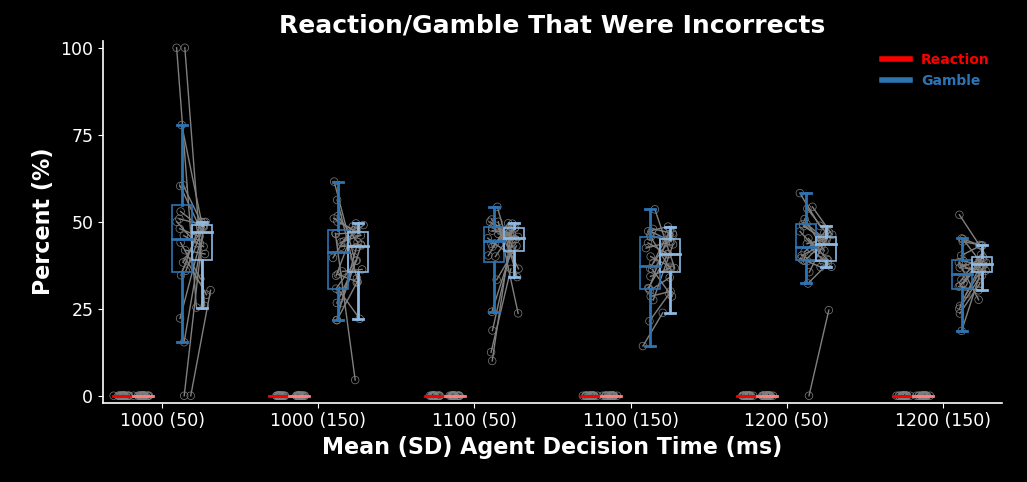

In [208]:
# Out of x number of Reaction/Gamble decisions, how many of them were incorrectss
#! Gambles can drop to less than 50 bc some of them are indecisions!
data_metric1 = group.combine_all_subjects('perc_reactions_that_were_incorrects') 
data_metric2 = group.combine_all_subjects('perc_gambles_that_were_incorrects') 
true_player_metric1 = models_true.get_metric('score_metrics','prob_incorrect_reaction',
                                             'player_behavior','prob_selecting_reaction',
                                             metric_type='fit')*100
true_player_metric2 = models_true.get_metric('score_metrics','prob_incorrect_gamble',
                                             'player_behavior','prob_selecting_gamble',
                                             metric_type='fit')*100
# Out of x number of Reaction/Gamble decisions, how many of them were incorrectss
w,h = 13,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.33
pf.multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
pf.multi_boxplot(ax,true_player_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],true_player_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
pf.multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
pf.multi_boxplot(ax,true_player_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],true_player_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw)
ax.set_ylim(min(ylocs)-2,max(ylocs)+2)

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Reaction/Gamble That Were Incorrects')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'indecisions_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Reaction/Gamble That Were Indecisions

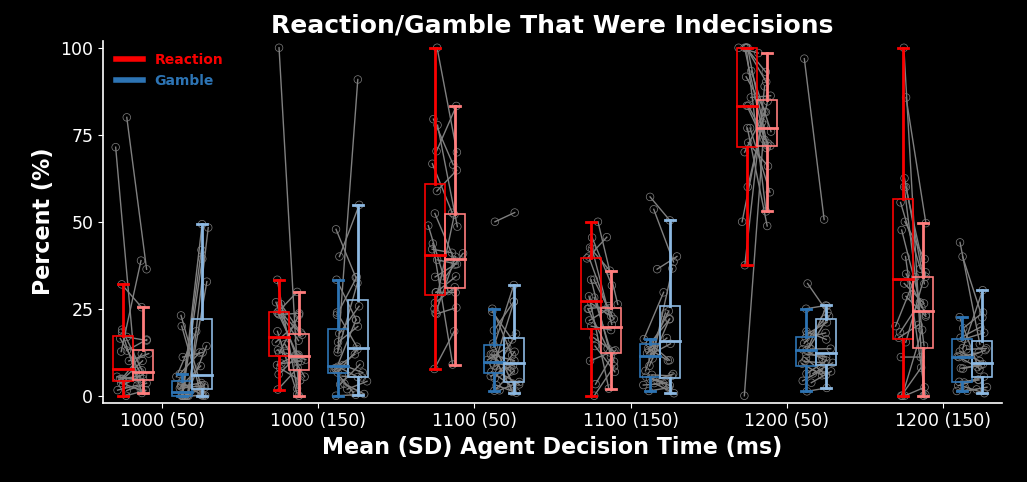

In [210]:
# Out of x number of Reaction/Gamble decisions, how many of them were indecisionss
data_metric1 = group.combine_all_subjects('perc_reactions_that_were_indecisions') 
data_metric2 = group.combine_all_subjects('perc_gambles_that_were_indecisions') 
true_player_metric1 = models_true.get_metric('score_metrics','prob_indecision_reaction',
                                             'player_behavior','prob_selecting_reaction',
                                             metric_type='fit')*100
true_player_metric2 = models_true.get_metric('score_metrics','prob_indecision_gamble',
                                             'player_behavior','prob_selecting_gamble',
                                             metric_type='fit')*100
# Out of x number of Reaction/Gamble decisions, how many of them were indecisionss
w,h = 13,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.33
pf.multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
pf.multi_boxplot(ax,true_player_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],true_player_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
pf.multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
pf.multi_boxplot(ax,true_player_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],true_player_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw)
ax.set_ylim(min(ylocs)-2,max(ylocs)+2)

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Reaction/Gamble That Were Indecisions')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'indecisions_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

# Unity Plots

Decision Time

In [ ]:
data_metric = np.nanmedian(group.player_task_leave_time,axis=2) 
optimal_metric = grouped_model_tuned.wtd_optimal_leave_target_time
xlocs = np.arange(0,1750,250)
ylocs = xlocs
ax1_xlocs = np.linspace(0.25,0.85,num_subjects)
for i in range(num_blocks):
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.5, 1]},figsize = (10,5),dpi=125)   
    ax0.scatter(optimal_metric[:,i], data_metric[:,i],facecolors='none',edgecolors=wheel.rak_blue)
    ax0.plot(xlocs,ylocs, color = wheel.dark_grey)
    ax0.set_xlim(0,xlocs[-1])
    ax0.set_ylim(0,ylocs[-1])
    ax0.set_xlabel('Optimal Decision Time (ms)')
    ax0.set_ylabel('Participant Median\nDecision Time (ms)')
    ax0.set_title(f'{trial_block_titles[i]}')
    ax0.set_xticks(xlocs)
    ax0.set_yticks(ylocs)

    diff = data_metric[:,i] - optimal_metric[:,i] 
    ax1.scatter(ax1_xlocs,diff,facecolors='none',edgecolors=wheel.rak_blue)
    ax1.axhline(zorder=0,linestyle='--')
    max_diff = np.max(abs(diff))

    arrow_length = max_diff 
    head_length = 0.2*arrow_length
    arrow_x_init = -0.25
    arrow_y_init = max_diff/10
    
    text_y1 = arrow_length/2 + arrow_y_init
    text_y2 = -arrow_length/2 - arrow_y_init
    
    ax1.arrow(arrow_x_init,arrow_y_init,0, arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'left',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y1,'Greater Mean\nDecision Time',rotation = 90, fontweight='bold',ha='center',va='center',fontsize=9)
    ax1.arrow(arrow_x_init,-arrow_y_init,0,-arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'right',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y2,'Lesser Mean\nDecision Time',rotation = 90, fontweight='bold',ha='center',va='center',fontsize = 9)
    
    ax1.set_ylim(-max_diff-(1/2)*max_diff,max_diff+(1/2)*max_diff)
    ax1.set_xlim(-0.3,1.2)
    ax1.set_xticks([])
    ax1.spines.bottom.set_visible(False)

NameError: name 'grouped_model_tuned' is not defined

Wins

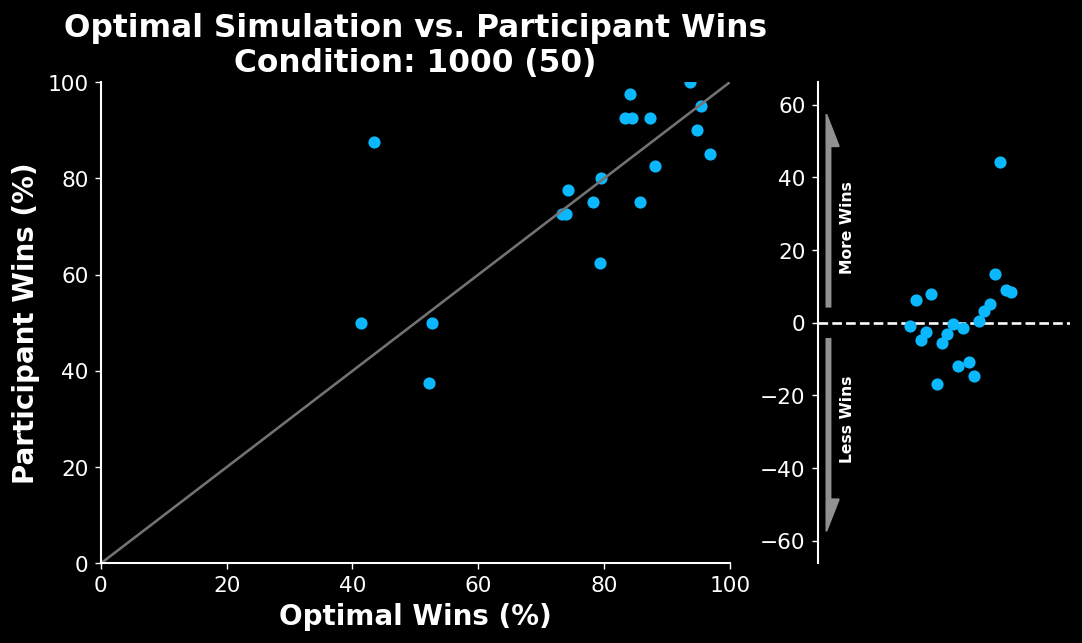

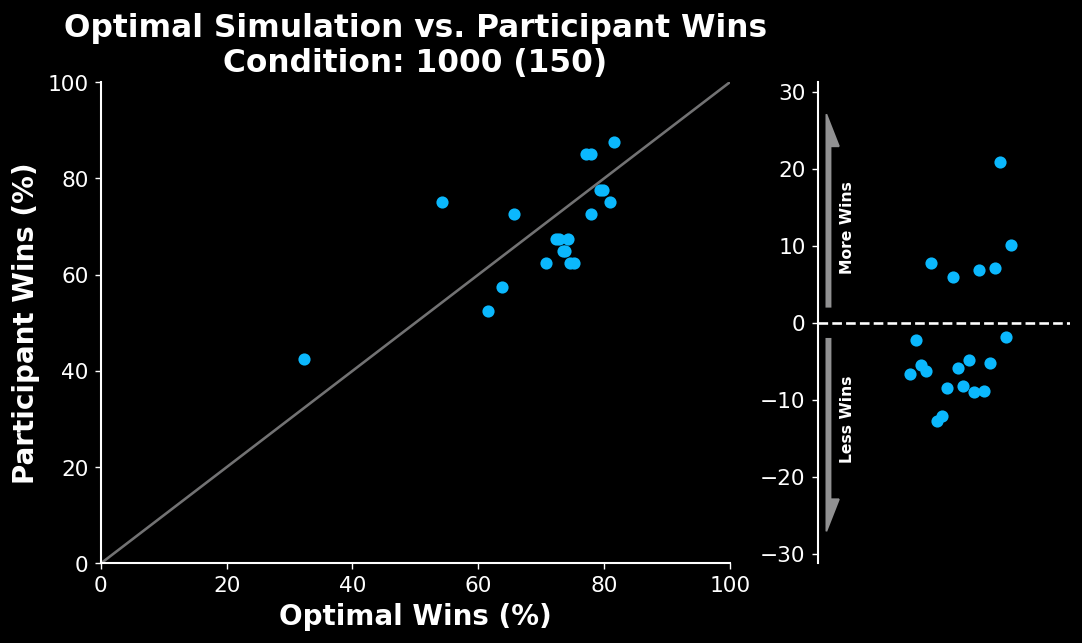

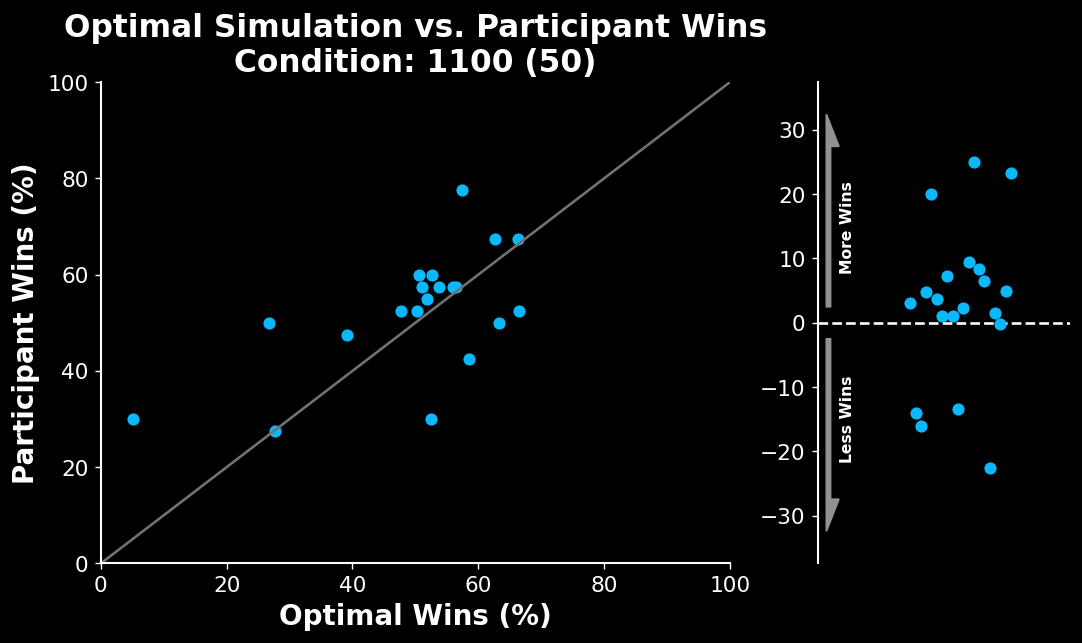

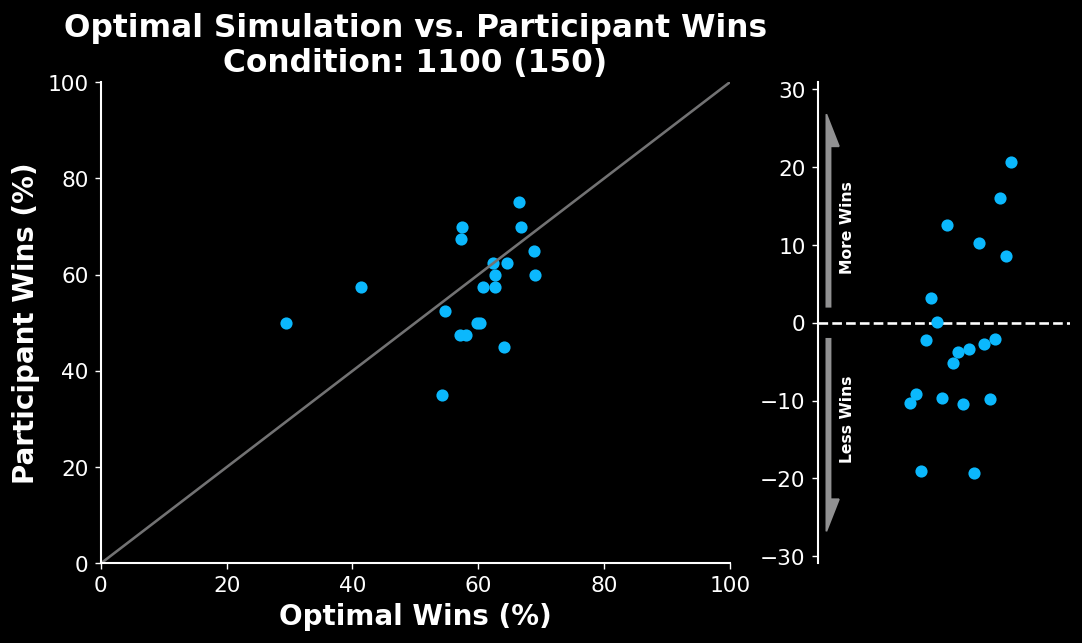

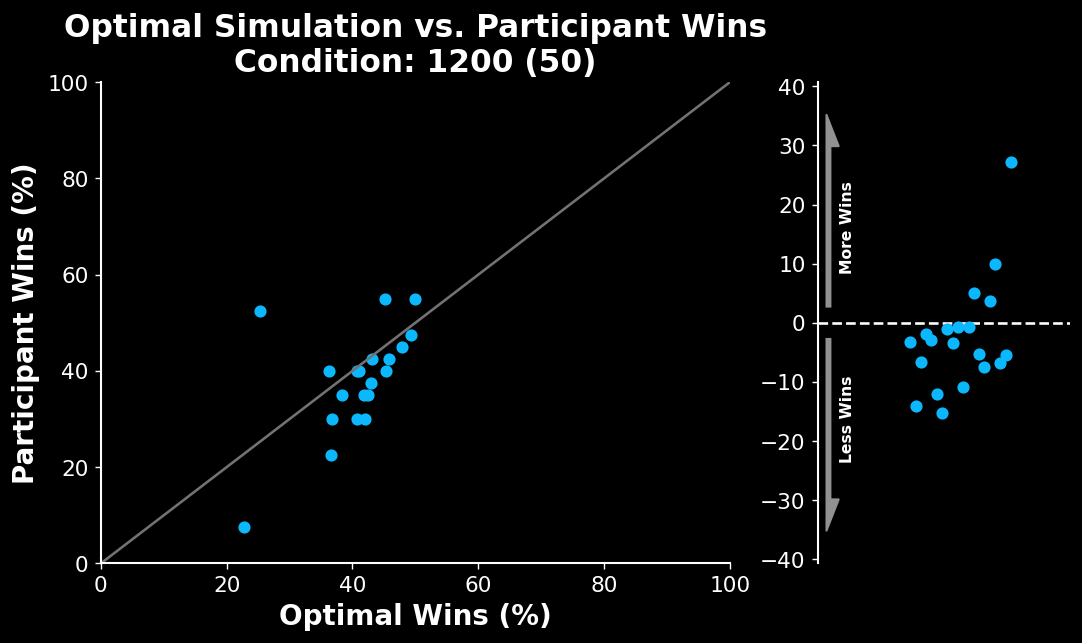

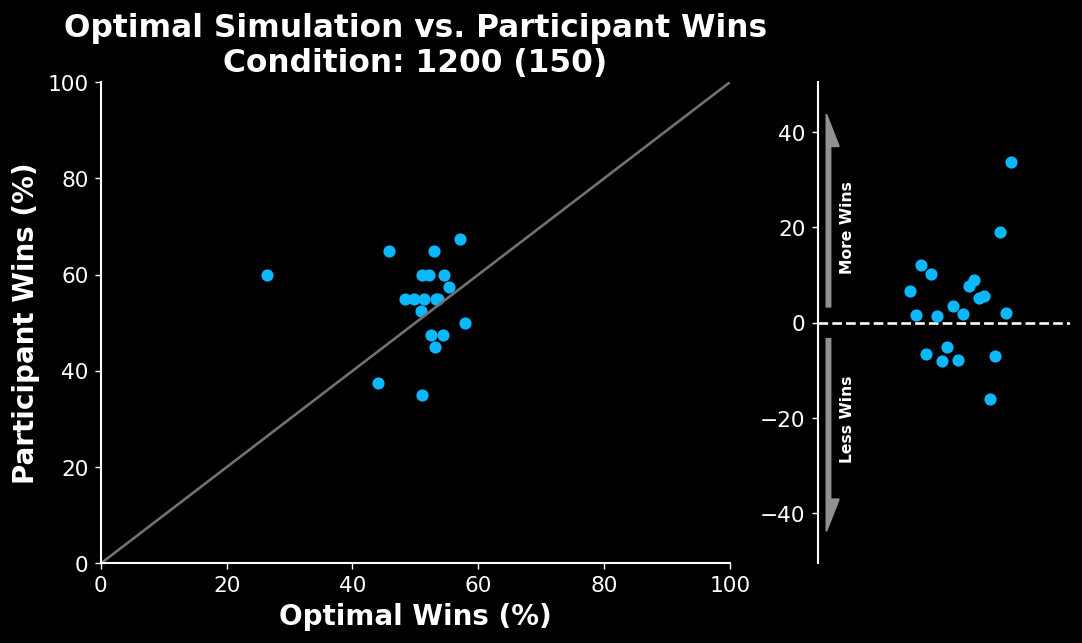

In [ ]:
data_metric = group.combine_all_subjects('player_perc_wins') 
optimal_metric = grouped_model_tuned.perc_win_optimal_calc
xlocs = np.arange(0,125,25)
ylocs = xlocs
ax1_xlocs = np.linspace(0.25,0.85,num_subjects)
for i in range(num_blocks):
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.5, 1]},figsize = (10,5),dpi=125)   
    ax0.scatter(optimal_metric[:,i], data_metric[:,i])
    ax0.plot(xlocs,ylocs, color = wheel.dark_grey)
    ax0.set_xlim(xlocs[0],xlocs[-1])
    ax0.set_ylim(ylocs[0],ylocs[-1])
    ax0.set_xlabel('Optimal Wins (%)')
    ax0.set_ylabel('Participant Wins (%)')
    ax0.set_title(f'Optimal Simulation vs. Participant Wins\nCondition: {trial_block_titles[i]}')
    
    
    diff = data_metric[:,i] - optimal_metric[:,i] 
    ax1.scatter(ax1_xlocs,diff)
    ax1.axhline(zorder=0,linestyle='--')
    max_diff = np.max(abs(diff))

    arrow_length = max_diff 
    head_length = 0.2*arrow_length
    arrow_x_init = -0.25
    arrow_y_init = max_diff/10
    
    text_y1 = arrow_length/2 + arrow_y_init
    text_y2 = -arrow_length/2 - arrow_y_init
    
    ax1.arrow(arrow_x_init,arrow_y_init,0, arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'left',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y1,'More Wins',rotation = 90, fontweight='bold',ha='center',va='center',fontsize=9)
    ax1.arrow(arrow_x_init,-arrow_y_init,0,-arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'right',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y2,'Less Wins',rotation = 90, fontweight='bold',ha='center',va='center',fontsize = 9)
    
    ax1.set_ylim(-max_diff-(1/2)*max_diff,max_diff+(1/2)*max_diff)
    ax1.set_xlim(-0.3,1.2)
    ax1.set_xticks([])
    ax1.spines.bottom.set_visible(False)

Indecisions

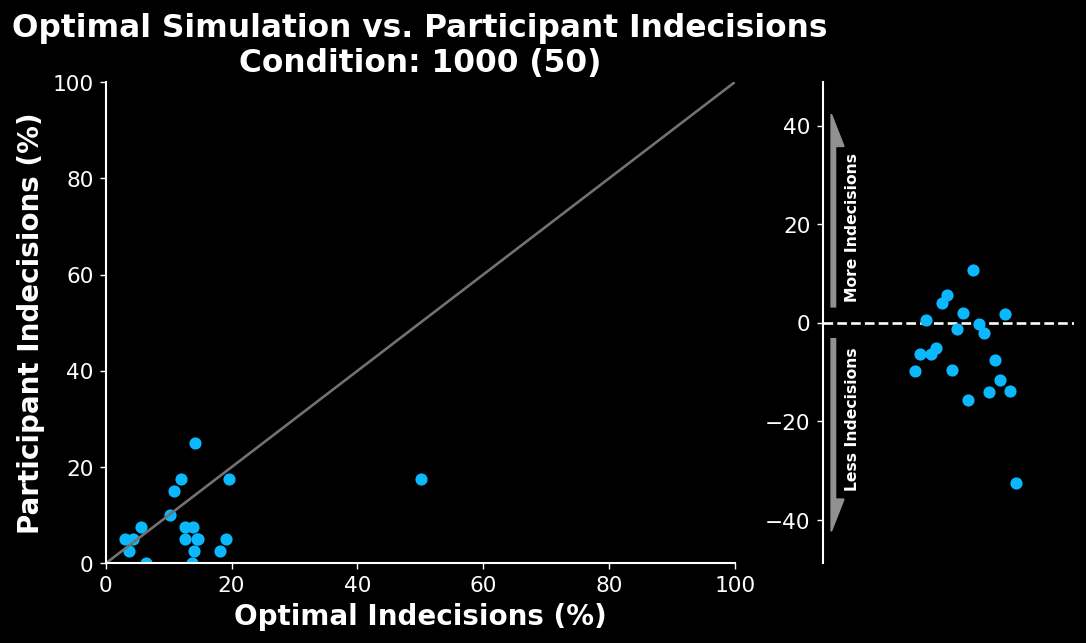

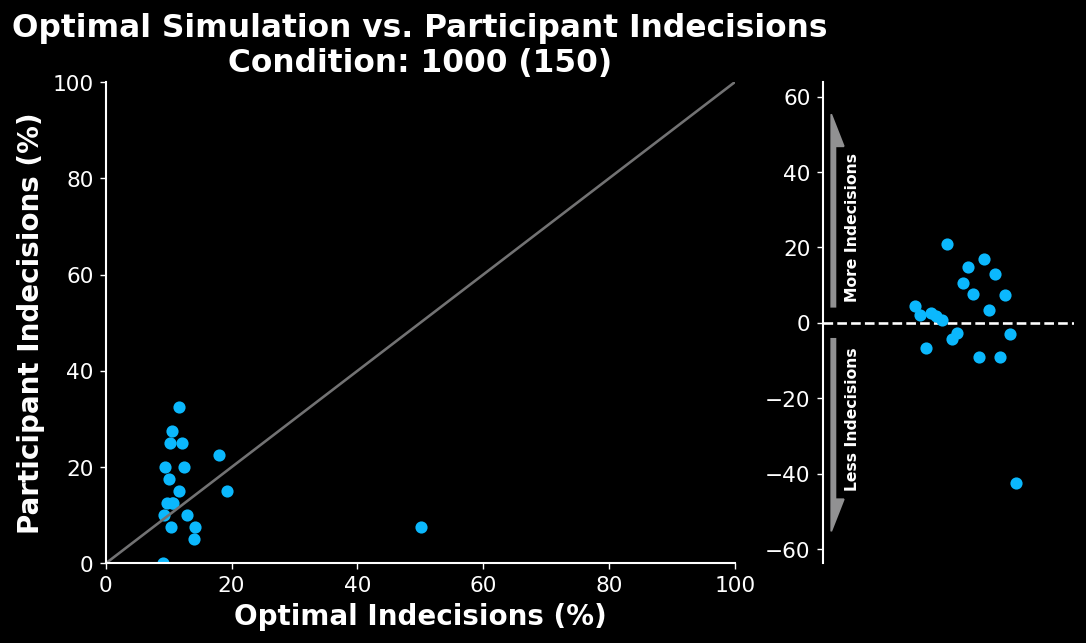

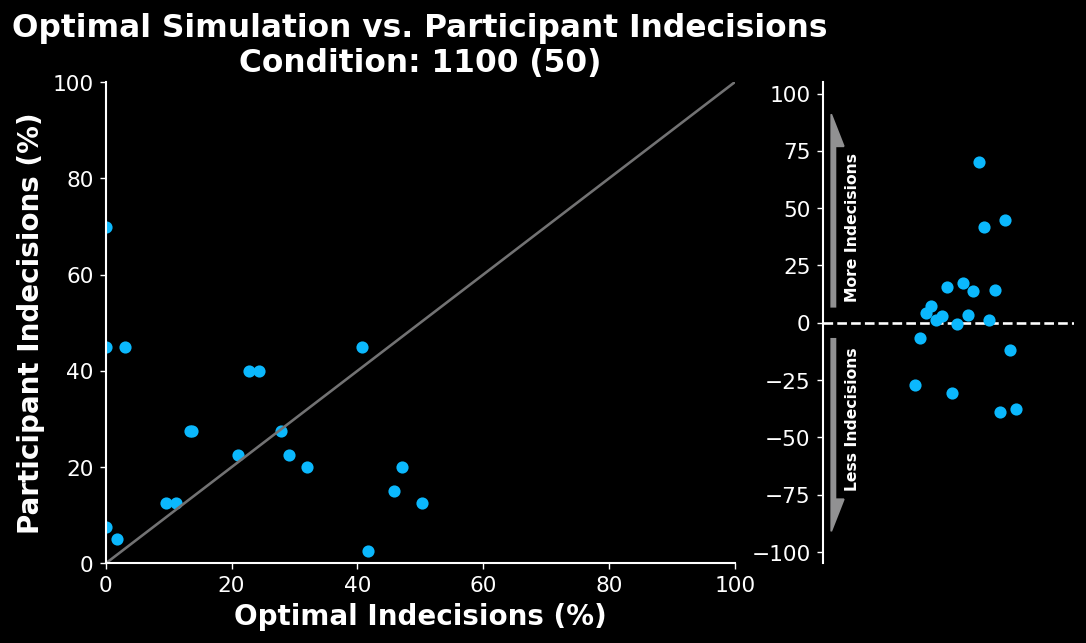

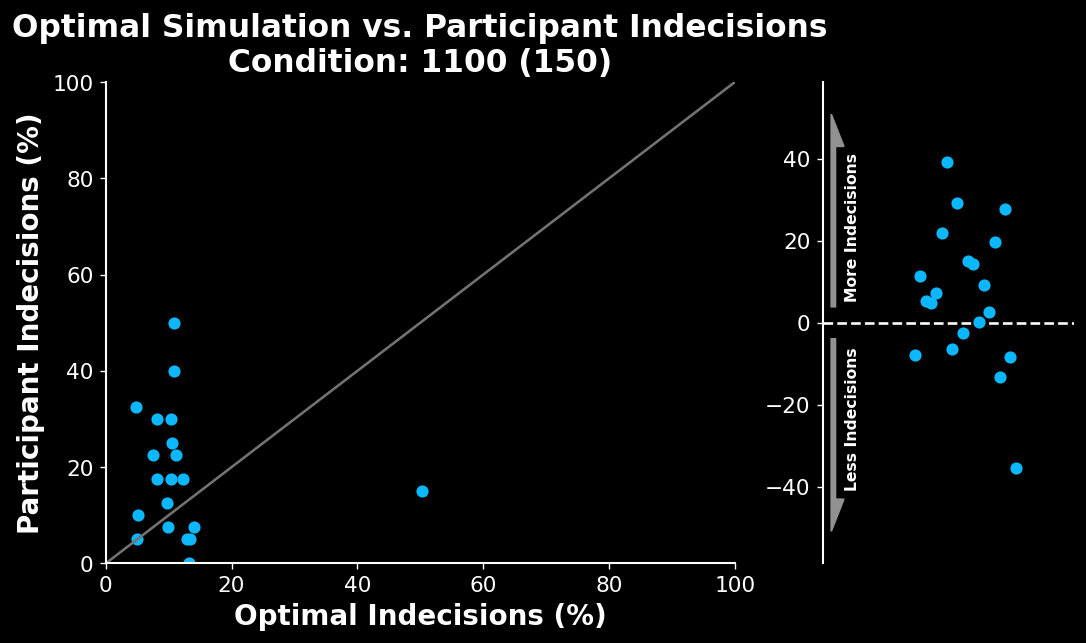

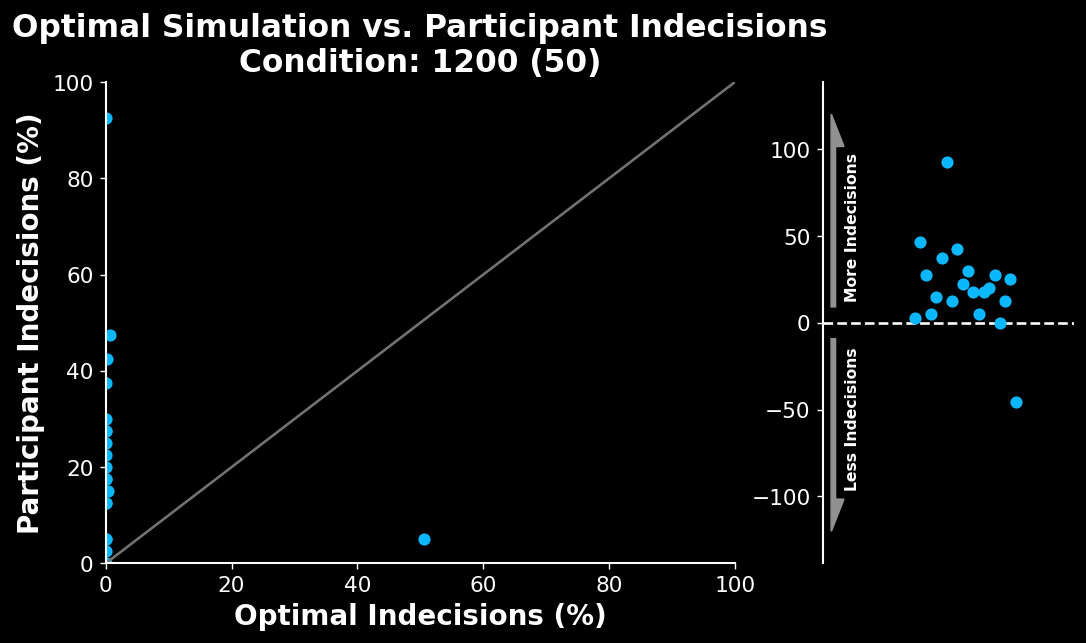

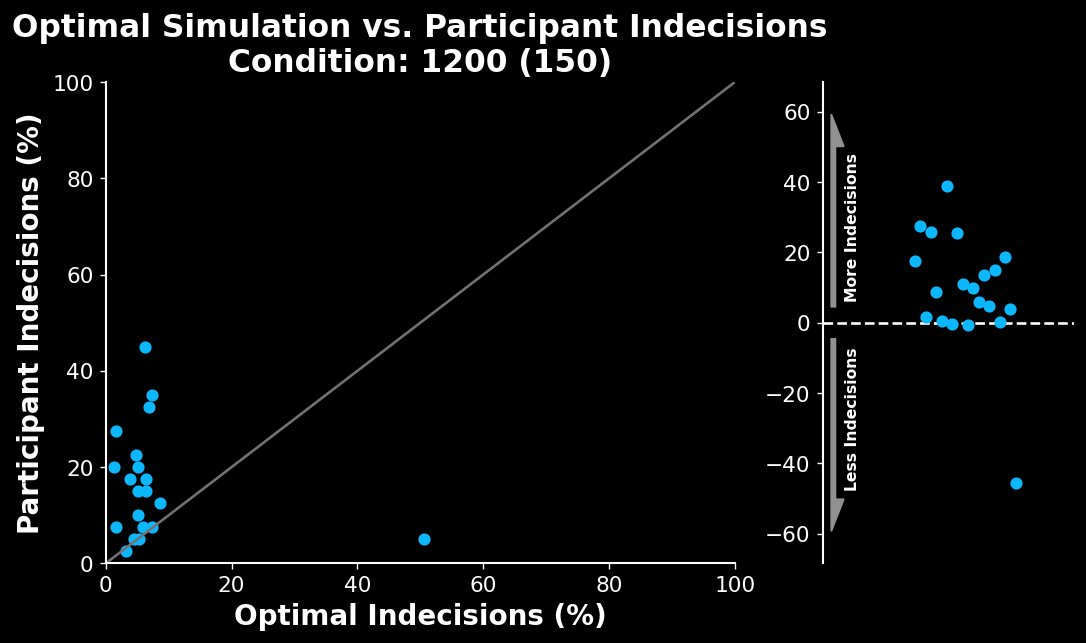

In [ ]:
data_metric = group.combine_all_subjects('player_perc_indecisions') 
optimal_metric = grouped.perc_indecision_optimal_calc
xlocs = np.arange(0,125,25)
ylocs = xlocs
ax1_xlocs = np.linspace(0.25,0.85,num_subjects)
for i in range(num_blocks):
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.5, 1]},figsize = (10,5),dpi=125)   
    ax0.scatter(optimal_metric[:,i], data_metric[:,i])
    ax0.plot(xlocs,ylocs, color = wheel.dark_grey)
    ax0.set_xlim(xlocs[0],xlocs[-1])
    ax0.set_ylim(ylocs[0],ylocs[-1])
    ax0.set_xlabel('Optimal Indecisions (%)')
    ax0.set_ylabel('Participant Indecisions (%)')
    ax0.set_title(f'Optimal Simulation vs. Participant Indecisions\nCondition: {trial_block_titles[i]}')
    
    
    diff = data_metric[:,i] - optimal_metric[:,i] 
    ax1.scatter(ax1_xlocs,diff)
    ax1.axhline(zorder=0,linestyle='--')
    max_diff = np.max(abs(diff))

    arrow_length = max_diff 
    head_length = 0.2*arrow_length
    arrow_x_init = -0.25
    arrow_y_init = max_diff/10
    
    text_y1 = arrow_length/2 + arrow_y_init
    text_y2 = -arrow_length/2 - arrow_y_init
    
    ax1.arrow(arrow_x_init,arrow_y_init,0, arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'left',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y1,'More Indecisions',rotation = 90, fontweight='bold',ha='center',va='center',fontsize=9)
    ax1.arrow(arrow_x_init,-arrow_y_init,0,-arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'right',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y2,'Less Indecisions',rotation = 90, fontweight='bold',ha='center',va='center',fontsize = 9)
    
    ax1.set_ylim(-max_diff-(1/2)*max_diff,max_diff+(1/2)*max_diff)
    ax1.set_xlim(-0.3,1.2)
    ax1.set_xticks([])
    ax1.spines.bottom.set_visible(False)

Incorrects

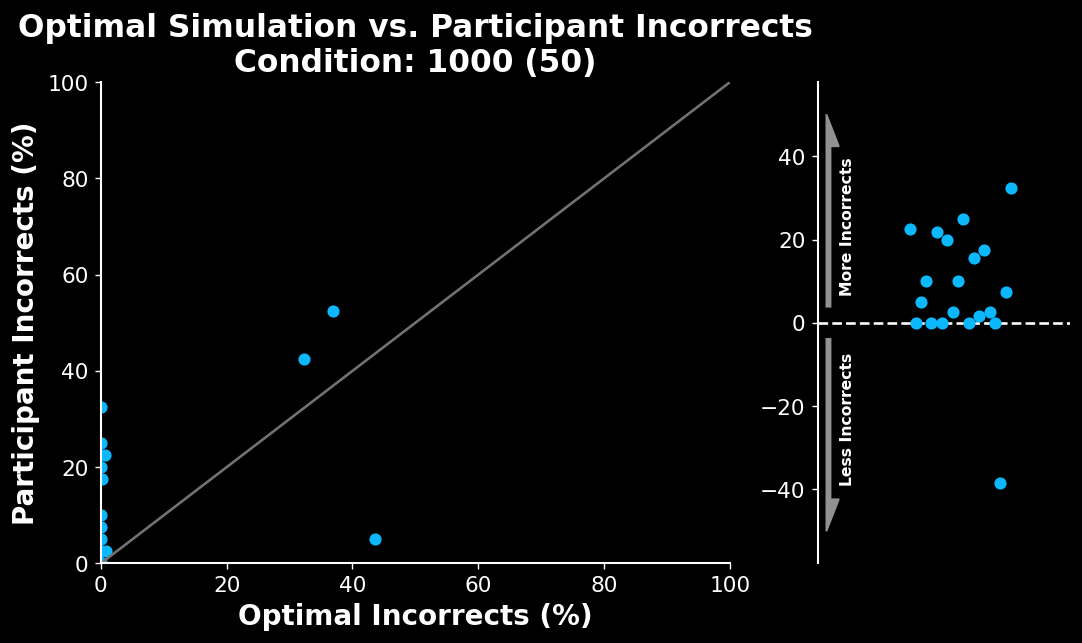

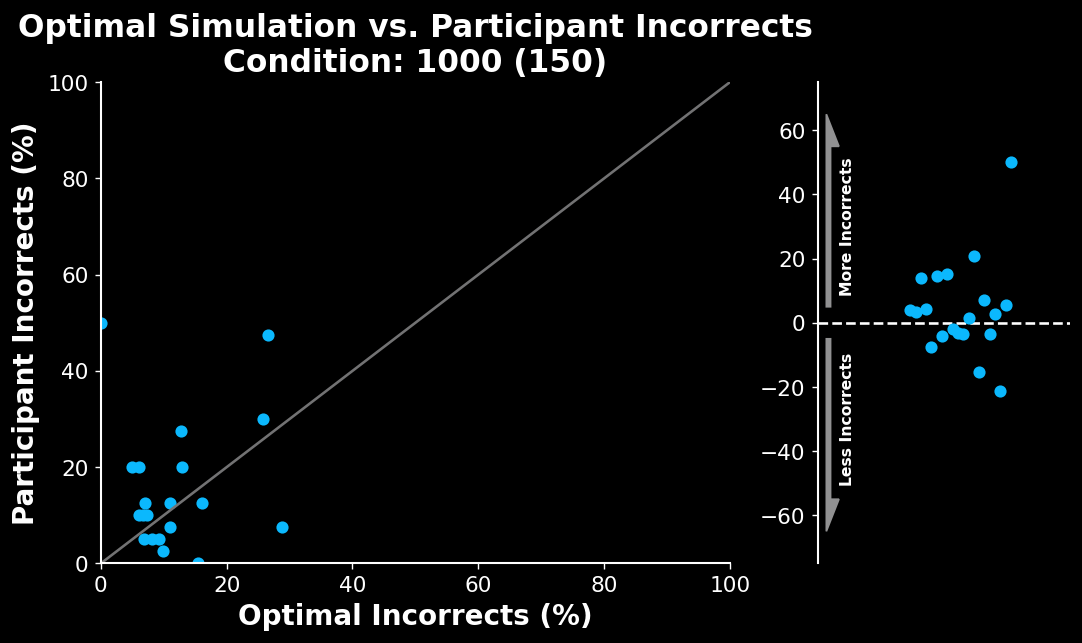

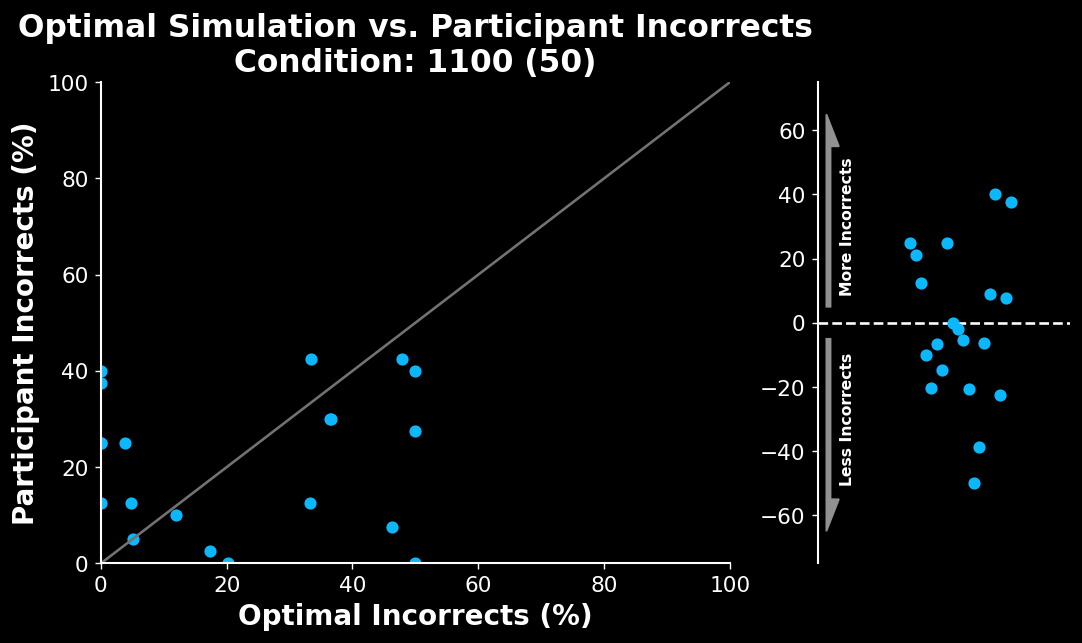

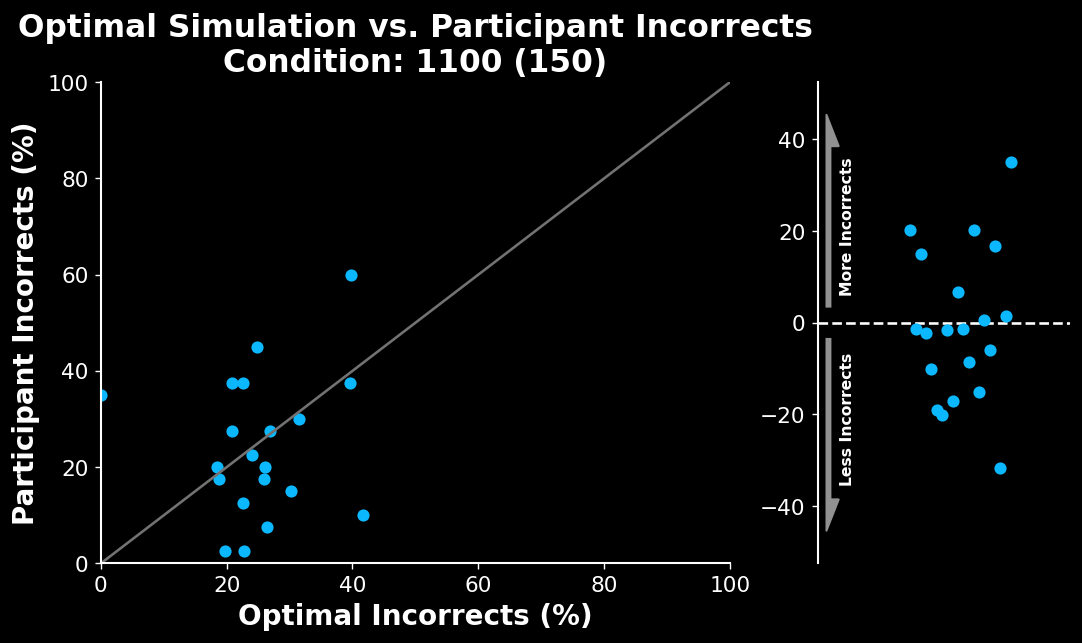

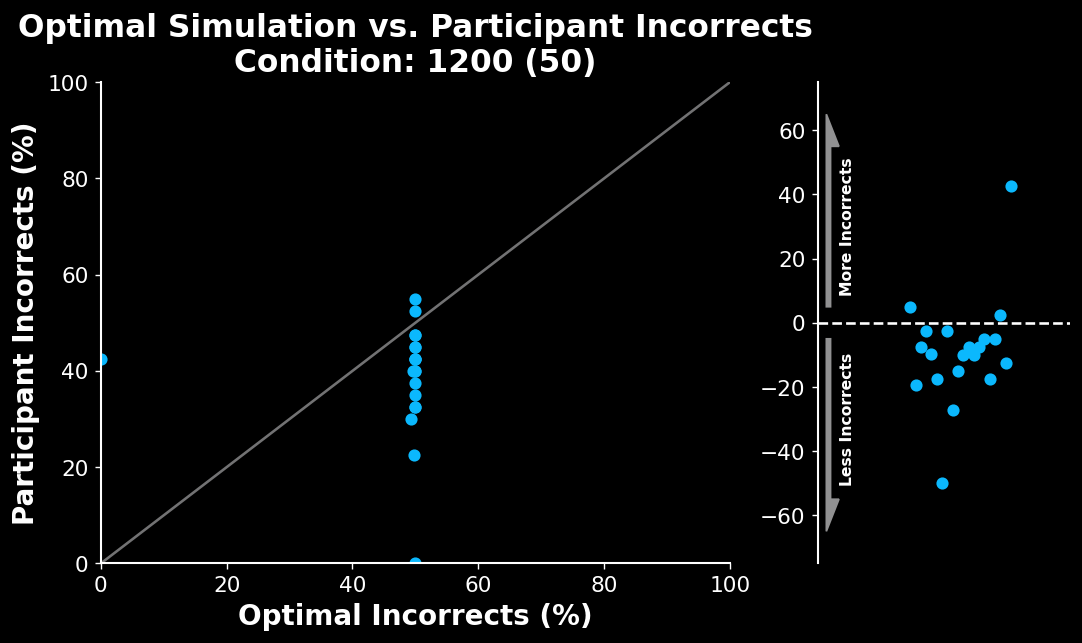

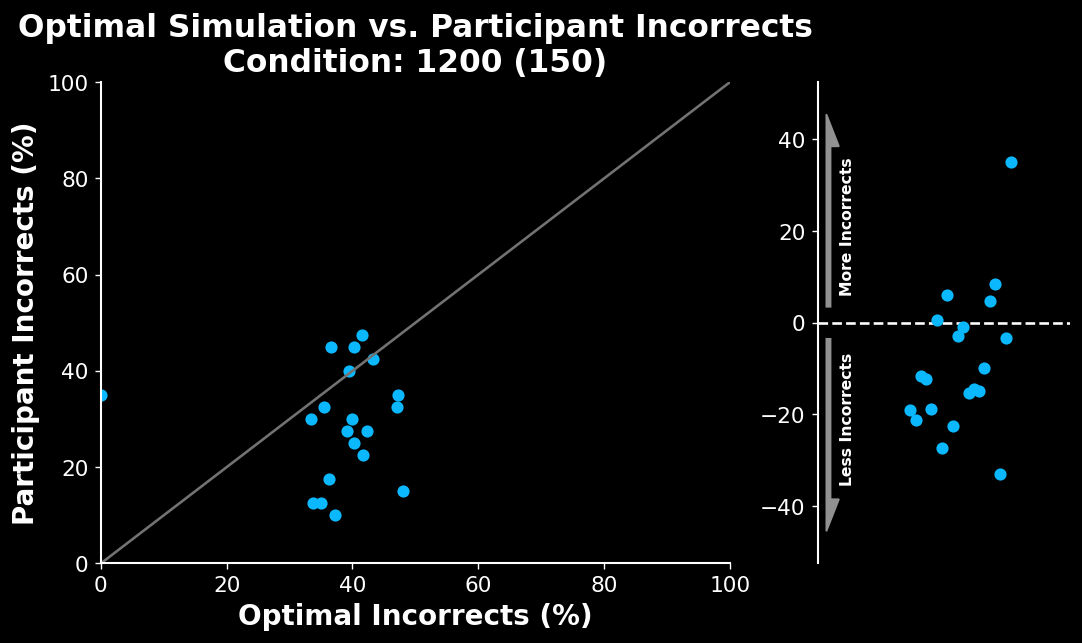

In [ ]:
data_metric = group.combine_all_subjects('player_perc_incorrects') 
optimal_metric = grouped.perc_incorrect_optimal_calc
xlocs = np.arange(0,125,25)
ylocs = xlocs
ax1_xlocs = np.linspace(0.25,0.85,num_subjects)
for i in range(num_blocks):
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.5, 1]},figsize = (10,5),dpi=125)   
    ax0.scatter(optimal_metric[:,i], data_metric[:,i])
    ax0.plot(xlocs,ylocs, color = wheel.dark_grey)
    ax0.set_xlim(xlocs[0],xlocs[-1])
    ax0.set_ylim(ylocs[0],ylocs[-1])
    ax0.set_xlabel('Optimal Incorrects (%)')
    ax0.set_ylabel('Participant Incorrects (%)')
    ax0.set_title(f'Optimal Simulation vs. Participant Incorrects\nCondition: {trial_block_titles[i]}')
    
    
    diff = data_metric[:,i] - optimal_metric[:,i] 
    ax1.scatter(ax1_xlocs,diff)
    ax1.axhline(zorder=0,linestyle='--')
    max_diff = np.max(abs(diff))

    arrow_length = max_diff 
    head_length = 0.2*arrow_length
    arrow_x_init = -0.25
    arrow_y_init = max_diff/10
    
    text_y1 = arrow_length/2 + arrow_y_init
    text_y2 = -arrow_length/2 - arrow_y_init
    
    ax1.arrow(arrow_x_init,arrow_y_init,0, arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'left',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y1,'More Incorrects',rotation = 90, fontweight='bold',ha='center',va='center',fontsize=9)
    ax1.arrow(arrow_x_init,-arrow_y_init,0,-arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'right',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y2,'Less Incorrects',rotation = 90, fontweight='bold',ha='center',va='center',fontsize = 9)
    
    ax1.set_ylim(-max_diff-(1/2)*max_diff,max_diff+(1/2)*max_diff)
    ax1.set_xlim(-0.3,1.2)
    ax1.set_xticks([])
    ax1.spines.bottom.set_visible(False)